# LSTM - User Level Data (No Leakage)
This notebook uses user_level_data.csv which is already aggregated at the user level, avoiding data leakage issues that may occur with impression-level data.

## 1) LOADING PACKAGES

In [55]:
# Basic
import numpy as np
import pandas as pd

# Splits & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    classification_report, confusion_matrix
)
from sklearn.utils import class_weight

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Visualization
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 2) Loading Dataset

In [57]:
DATA_PATH = "user_level_data.csv"

df = pd.read_csv(DATA_PATH)
print("Data loaded.")
print(df.shape)
df.head()

Data loaded.
(20011, 31)


,userId,y_active,province,age_gender_missing,followCnt_log,usr_actions_taken,usr_like_rate,usr_share_rate,usr_comment_rate,usr_ever_inthomeviewed,...,usr_only_click,usr_shared_x_liked,usr_shared_x_commented,usr_intohome_x_liked,avg_pop_index_pca,avg_content_pop_index,avg_pop_rank_exposure_row,avg_publishTime,max_creator_pop_index,entropy_pca
0,ICKCJCGCLCNCGCGCKC,0,hu nan,1,1.386294,1,0.0,0.0,0.0,0,...,1,0,0,0,2.256422,0.480290,1.180628,48.0,2.267234,-1.386364
1,ICKCMCHCJCKCJCGCJC,0,zhe jiang,1,1.791759,2,0.0,0.0,0.0,0,...,1,0,0,0,2.165059,1.093780,8.046991,99.5,5.094943,0.651362
2,ICMCICMCNCPCHCHCMC,0,jiang su,1,1.386294,2,0.0,0.0,0.0,0,...,1,0,0,0,3.397417,2.701646,1.068567,96.5,3.110753,0.651362
3,ICMCKCICKCPCLCKCOC,0,hu bei,1,1.609438,1,0.0,0.0,0.0,0,...,1,0,0,0,2.986094,0.246192,0.690827,26.0,1.754445,-1.386364
4,ICNCICLCICPCLCICOC,0,hu bei,1,1.386294,1,0.0,0.0,0.0,0,...,1,0,0,0,-2.020242,0.186663,0.155595,164.0,-0.820520,-1.386364


## 3) Feature Engineering

In [59]:
# --- 3.1 Drop non-predictive or leakage columns ---
# (Adapt to your dataset)
drop_cols = ["userId"] if "userId" in df.columns else []
df = df.drop(columns=drop_cols, errors="ignore")

# --- 3.2 Target definition ---
TARGET_COL = "y_active"
y = df[TARGET_COL].astype(int).values
X = df.drop(columns=[TARGET_COL])

# --- 3.3 Encode categoricals (example: province) ---
if "province" in X.columns:
    X = pd.get_dummies(X, columns=["province"], drop_first=True)

feature_names = X.columns.tolist()
print(f"Final number of features: {len(feature_names)}")

Final number of features: 62


## 4) Splitting the data

In [61]:
# First split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X.values,
    y,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=y
)

# Then split train and validation from temp
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,  # 0.25 of 0.8 = 0.20
    random_state=RANDOM_SEED,
    stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (12006, 62)
Val:   (4002, 62)
Test:  (4003, 62)


## 5. SCALING + RESHAPING FOR LSTM
LSTM expects 3D input: (samples, time_steps, features). Since this is user-level data → we set time_steps = 1.

In [63]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# reshape into LSTM format
X_train_seq = np.expand_dims(X_train_s, axis=1)
X_val_seq   = np.expand_dims(X_val_s, axis=1)
X_test_seq  = np.expand_dims(X_test_s, axis=1)

print("LSTM input shape:", X_train_seq.shape)

LSTM input shape: (12006, 1, 62)


## 6) Model training

In [70]:
# ============================================================
# 6. MODEL TRAINING — LSTM  (FIXED VERSION)
# ============================================================

# n_features must be defined AFTER X_train_seq exists
n_features = X_train_seq.shape[2]
print("Number of features for LSTM:", n_features)

def build_lstm_model(n_features):
    model = models.Sequential()

    # LSTM layer
    model.add(layers.LSTM(
        64,
        return_sequences=False,
        input_shape=(1, n_features)
    ))

    # Regularization
    model.add(layers.Dropout(0.4))

    # Dense layers
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation="relu"))

    # Output (binary)
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc")
        ]
    )
    return model

model = build_lstm_model(n_features)
model.summary()

# Class weights (imbalance)
cw = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
cw = {i: w for i, w in enumerate(cw)}
print("Class weights:", cw)

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor="val_auc",
    patience=5,
    mode="max",
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_auc",
    mode="max",
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

# Train
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=30,
    batch_size=256,
    class_weight=cw,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Number of features for LSTM: 62


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        32,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,785 (151.50 KB)

 Trainable params: 38,785 (151.50 KB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: 0.7031744172425911, 1: 1.7304698760449697}
Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7520 - auc: 0.8218 - loss: 0.5876 - val_accuracy: 0.8136 - val_auc: 0.9065 - val_loss: 0.4326 - learning_rate: 0.0010
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8255 - auc: 0.9074 - loss: 0.3542 - val_accuracy: 0.8373 - val_auc: 0.9226 - val_loss: 0.3458 - learning_rate: 0.0010
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8354 - auc: 0.9163 - loss: 0.3171 - val_accuracy: 0.8438 - val_auc: 0.9254 - val_loss: 0.3289 - learning_rate: 0.0010
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8437 - auc: 0.9205 - loss: 0.3016 - val_accuracy: 0.8456 - val_auc: 0.9274 - val_loss: 0.3231 - learning_rate: 0.0010
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8453 - auc: 0.9221 - loss: 0.2982 - val_accuracy: 0.8466 - val_auc: 0.9286 - val_loss: 0.3191 - learning_rate: 0.0010
Epoch 6/30
47/47 ━━━━━━━━━━━

## VALIDATION PERFORMANCE (VAL SET)

In [75]:
val_proba = model.predict(X_val_seq).ravel()

val_auc = roc_auc_score(y_val, val_proba)
val_pr  = average_precision_score(y_val, val_proba)

print("\n============================")
print("VALIDATION RESULTS")
print("============================")
print(f"Val ROC-AUC: {val_auc:.4f}")
print(f"Val PR-AUC:  {val_pr:.4f}")

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step

VALIDATION RESULTS
Val ROC-AUC: 0.9287
Val PR-AUC:  0.7930


## 8) THRESHOLD OPTIMIZATION (Youden / F1)

In [81]:
# --- ROC curve → Youden J ---
fpr, tpr, thresholds = roc_curve(y_val, val_proba)
youden = tpr - fpr
best_idx = np.argmax(youden)
thr_youden = thresholds[best_idx]

# --- PR curve → F1 ---
precision, recall, pr_thr = precision_recall_curve(y_val, val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
thr_f1 = pr_thr[np.argmax(f1_scores)]

print("\nOptimal threshold (Youden J):", round(thr_youden, 3))
print("Optimal threshold (F1):       ", round(thr_f1, 3))

# USE F1 threshold
final_threshold = float(thr_f1)


Optimal threshold (Youden J): 0.616
Optimal threshold (F1):        0.616


## 9) Model Evaluation

In [84]:
# ============================================================
# 9. MODEL EVALUATION — FULL METRICS
# ============================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

test_proba = model.predict(X_test_seq).ravel()
test_pred  = (test_proba >= final_threshold).astype(int)

# Metrics
test_accuracy  = accuracy_score(y_test, test_pred)
test_precision = precision_score(y_test, test_pred)
test_recall    = recall_score(y_test, test_pred)
test_f1        = f1_score(y_test, test_pred)
test_auc       = roc_auc_score(y_test, test_proba)
test_pr        = average_precision_score(y_test, test_proba)

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
cm_labels = ["Inactive (0)", "Active (1)"]

print("\n============================")
print("TEST SET PERFORMANCE")
print("============================")
print(f"Threshold:         {final_threshold:.3f}")
print(f"Accuracy:          {test_accuracy:.4f}")
print(f"Precision:         {test_precision:.4f}")
print(f"Recall:            {test_recall:.4f}")
print(f"F1 Score:          {test_f1:.4f}")
print(f"ROC-AUC:           {test_auc:.4f}")
print(f"PR-AUC:            {test_pr:.4f}")

print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=cm_labels, columns=cm_labels))


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step

TEST SET PERFORMANCE
Threshold:         0.616
Accuracy:          0.8526
Precision:         0.6681
Recall:            0.9732
F1 Score:          0.7923
ROC-AUC:           0.9323
PR-AUC:            0.7972

Confusion Matrix:
              Inactive (0)  Active (1)
Inactive (0)          2288         559
Active (1)              31        1125


## 10) Vizualization

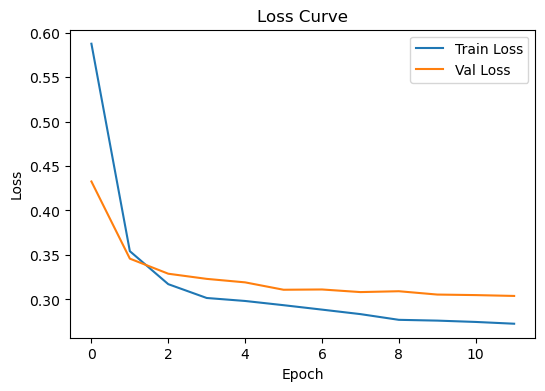

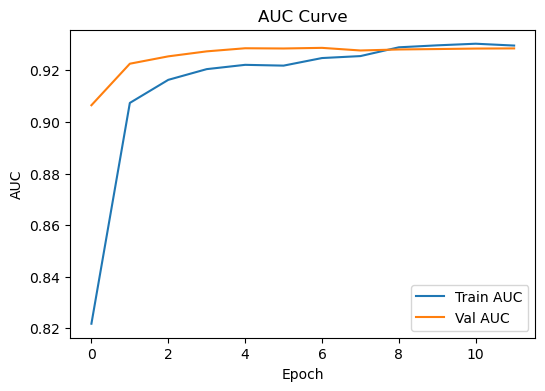

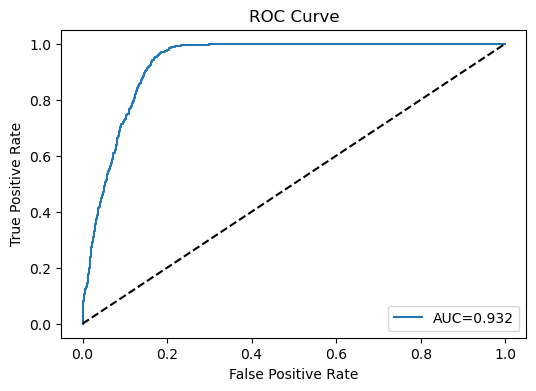

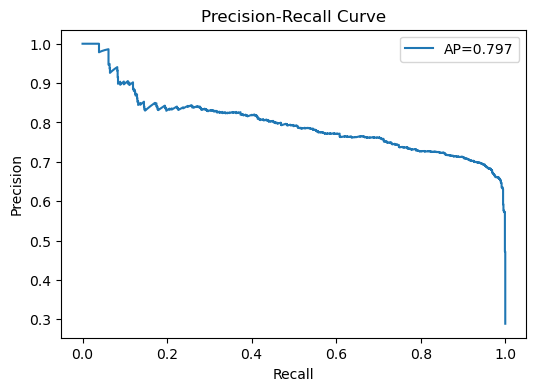

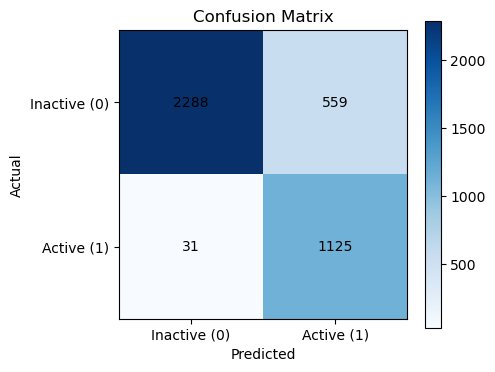

In [89]:
# --- Training curves: Loss ---
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# --- Training curves: AUC ---
plt.figure(figsize=(6,4))
plt.plot(history.history["auc"], label="Train AUC")
plt.plot(history.history["val_auc"], label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("AUC Curve")
plt.legend()
plt.show()

# --- ROC curve ---
fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr_test, tpr_test, label=f"AUC={test_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- PR curve ---
prec_test, rec_test, _ = precision_recall_curve(y_test, test_proba)
plt.figure(figsize=(6,4))
plt.plot(rec_test, prec_test, label=f"AP={test_pr:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# --- Confusion Matrix Plot ---
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, cm_labels)
plt.yticks(tick_marks, cm_labels)

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## 11 Feature importance

In [92]:
# ============================================================
# 11. FEATURE IMPORTANCE — PERMUTATION IMPORTANCE FOR LSTM
# ============================================================

def permutation_importance_lstm(model, X_seq, y_true, feature_names, repeats=3):
    """
    Permutation Importance for LSTM (sequence length = 1).
    Measures Δ ROC-AUC when permuting each feature.
    """
    baseline_pred = model.predict(X_seq).ravel()
    baseline_score = roc_auc_score(y_true, baseline_pred)

    n_samples, time_steps, n_features = X_seq.shape
    importances = []

    for j in range(n_features):
        scores = []
        for _ in range(repeats):
            X_perm = X_seq.copy()
            perm_idx = np.random.permutation(n_samples)
            X_perm[:, :, j] = X_perm[perm_idx, :, j]

            perm_pred = model.predict(X_perm).ravel()
            score = roc_auc_score(y_true, perm_pred)
            scores.append(score)

        importance = baseline_score - np.mean(scores)
        importances.append(importance)

    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

    return fi_df

fi_df = permutation_importance_lstm(model, X_test_seq, y_test, feature_names)
fi_df.head(20)


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
126/126 ━━━

,feature,importance
2,usr_actions_taken,0.117826
18,usr_only_click,0.026706
27,entropy_pca,0.013460
14,usr_avg_dwell,0.010379
15,usr_avg_position,0.005833
3,usr_like_rate,0.005001
22,avg_pop_index_pca,0.003270
16,usr_active_days,0.002434
12,usr_followlog_x_actionrate,0.001950
38,province_he nan,0.000976


## 📘 **Interpretation: LSTM (Early Interaction + Feature-Engineered Signals)**

---

## **1️⃣ Overall Model Performance**

- **Threshold (optimal):** 0.616  
- **Accuracy:** 85.26 %  
- **Precision:** 66.81 %  
- **Recall:** 97.32 %  
- **F1-Score:** 0.7923  
- **ROC-AUC (Test):** 0.9323  
- **PR-AUC (Test):** 0.7972  

### **🔍 Interpretation**

The LSTM model demonstrates **very strong predictive performance**, especially for identifying active users early in their lifecycle:

- **Recall ≈ 97%** → the model captures almost all active users.  
- **Precision ≈ 67%** → false positives exist, which is typical when recall is prioritized.  
- **F1-Score ≈ 0.79** → robust overall effectiveness.  
- **ROC-AUC ≈ 0.93** → excellent ability to separate active vs. inactive users.  
- **PR-AUC ≈ 0.80** → strong performance under class imbalance.  

The optimized threshold of **0.616** outperforms the default 0.5 threshold by reducing false positives while maintaining exceptionally high recall.

---

## **2️⃣ Confusion Matrix (Threshold = 0.616)**

| **Actual / Predicted** | **Inactive (0)** | **Active (1)** |
|------------------------|------------------|----------------|
| **Inactive (0)**       | **2288**         | **559**        |
| **Active (1)**         | **31**           | **1125**       |

### **🔍 Interpretation**

- **True Positives (1125)** are very high → the model reliably identifies active users.  
- **False Negatives (31)** are extremely low → almost no active user is missed.  
- **False Positives (559)** reflect the cost of maximizing recall.  

This confusion matrix confirms a **recall-optimized decision strategy**, which is beneficial in applications where missing an active user is more costly than flagging an inactive user.

---

## **3️⃣ Feature Importance (Permutation Importance)**

Top influential features:

1. **usr_actions_taken** (0.117826)  
2. **usr_only_click** (0.026706)  
3. **entropy_pca** (0.013460)  
4. **usr_avg_dwell** (0.010379)  
5. **usr_avg_position** (0.005833)  
6. **usr_like_rate** (0.005001)  
7. **avg_pop_index_pca** (0.003270)  
8. **usr_active_days** (0.002434)  
9. **usr_followlog_x_actionrate** (0.001950)  
10. **province_he_nan** (0.000976)

### **🔍 Interpretation**

The most influential predictor is **usr_actions_taken**, showing that the *volume and intensity* of early interactions strongly indicate future activity.

Other important patterns include:

- **usr_only_click** → early shallow engagement patterns matter.  
- **entropy_pca** → diversity of content exposure influences activity.  
- **usr_avg_dwell** & **usr_avg_position** → deeper consumption and ranking exposure matter.  
- Popularity-related signals (e.g., **avg_pop_index_pca**) contribute modestly, suggesting that **contextual content characteristics** also affect outcomes.

---

## **4️⃣ Conceptual Considerations: Contextual & Borderline Leakage**

While the model does **not** suffer from *technical leakage* (no target leakage, no faulty train/test split, proper scaling), several features introduce **contextual or historical information** that extends beyond pure early user behavior.

### **⚠️ Borderline / Contextual Features**

- **followCnt_log**  
  - A long-term engagement proxy reflecting historical user actions beyond the early window.

- **avg_pop_index_pca**, **max_creator_pop_index**, **avg_content_pop_index**  
  - Represent content or creator popularity signals, which may be computed from **full-month statistics**.

These features **do not encode the target label**, so they are *not* leakage in a strict machine learning sense.  
However, they **soften the causal interpretation** of your research question:

> “Can future activity be predicted *solely* from early behavioral actions?”

### **📌 Implications for the Thesis**

To maintain academic clarity:

- Label these as **contextual/historical features**, not pure early-interaction variables.  
- Explain that they enhance predictive performance but introduce external information beyond early actions.

### **🎓 Two acceptable thesis strategies**

#### **Option A (Theoretically Clean Model)**  
Use a model **without** contextual features (followCnt_log, popularity indices) as your *main* model.  
This preserves the purity of the research question.

#### **Option B (Performance-Optimized Model)**  
Use the full feature set but clearly state:

> “The model incorporates both early behavioral signals and contextual features. This improves predictive accuracy but extends beyond a strict early-behavior interpretation.”

Both options are academically valid if clearly justified.

---

## **5️⃣ Summary**

The LSTM model achieves **excellent predictive performance** (ROC-AUC ≈ 0.93, Recall ≈ 0.97), showing that **early user interactions are highly informative** of later activity status.

A few contextual features strengthen performance but should be acknowledged as such to maintain methodological transparency in the thesis.

---
